In [1]:
#%matplotlib notebook                      
import numpy as np                        # working with arrays
import matplotlib.pyplot as plt           # working with plots

from skimage import morphology as mrph
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.style.use('classic')

In [3]:
import warnings

Xmin = -200             # reactor boundaries
Xmax = +200
Ymin = -200
Ymax = +200

Xsize = Xmax-Xmin       # size of the X_Y grid
Ysize = Ymax-Ymin    
dx  = 1                 # space step in nm
dy  = dx                # dx = 8.5 nm

nX  = int(Xsize/dx)     # integer
nY  = int(Ysize/dy)

T  = 10000              # total time
dt = 1                  # time step
nt = int(T/dt)          # number of iterations

f      = 0.073          # equilibrium rate constant  
k_sol  = 0.135          # solidification rate

I_cr = 7.3              # quenching parameters
h = 55

delta = 1.96
Ds1i = 0.112            # diffusion constants 
Ds2i = Ds1i/delta
Di   = 0.21

CFLx = Di*dt/(dx**2)    # CFL satbility criterion

mf = 105
Xm,XM,Ym,YM =(Xmin/dx)/mf,(Xmax/dx)/mf,(Ymax/dx)/mf,(Ymin/dx)/mf
physical_boundaries = [Xm,XM,Ym,YM] # in um

ds0 = 1                 # rescaling factor, default = 1

if (CFLx > 0.24 ) : warnings.warn("\n  CFL* HAS BEEN REACHED: CFL={:.3f}".format(CFLx))

print('Grid size (rows):...................{}'.format(nY))
print('Estimated simulation time (min):....{:.2f}'.format((4.5e-4*nX+5.12e-3)**2.3*T/dt/60)) # empirical func.
print('CFL (CFL*=0.16):....................{:.3f}'.format(CFLx))

Grid size (rows):...................400
Estimated simulation time (min):....3.44
CFL (CFL*=0.16):....................0.210


In [4]:
import BranchDiatom as brd

S1I,S2I = brd.get_initial_seed('seed.png',0.4,dx,nX,nY) # Vmax=0.4

<IPython.core.display.Javascript object>


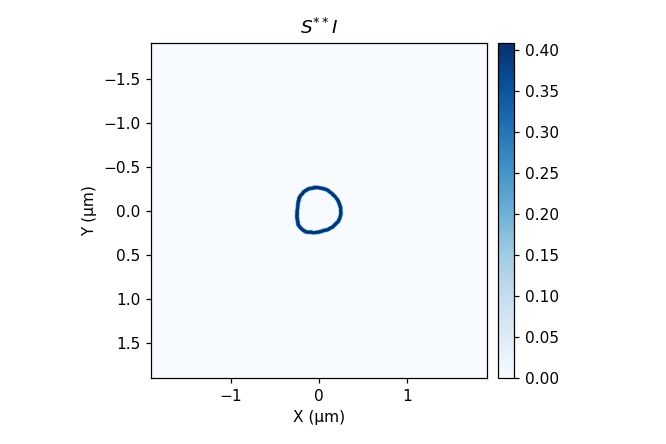

In [5]:
def plot_scale_bar(img,mgf,axes):
    im1 = axes.errorbar(np.shape(img)[0]*0.8,np.shape(img)[1]*0.08,\
                        xerr = (mgf*ds0/dx)/4, color='k', capsize=1,linewidth=2)
    im2 = axes.text(np.shape(img)[0]*0.8,np.shape(img)[1]*0.02,\
                   '500 nm', horizontalalignment='center', verticalalignment='top',fontsize = 10)
    return(im1,im2)

# plot pattern
fig, ax = plt.subplots(figsize = (6,4),dpi=100)

physical_boundaries = [Xm,XM,Ym,YM] # in um

ax = plt.subplot(111)
ax.set_title(r'$S^{**}I$')
im1 = ax.imshow(S2I, cmap='Blues',extent =physical_boundaries)

ax.set_xlabel('X (μm)')
ax.set_ylabel('Y (μm)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.10)
clb = fig.colorbar(im1, cax=cax, orientation='vertical')
plt.tight_layout()

#import get_valve_morphology as gvm

In [6]:
from tqdm.notebook import tqdm

T = 3000     # simulation time 
n = int(T/dt) # number of time steps 

I_cr = 7.05              # quenching parameters
h = 55

# load init. cond. for the reactants from a file 
S1I,S2I = brd.get_initial_seed('seed.png',0.4,dx,nX,nY) # Vmax=0.4
S2I = mrph.erosion(S2I, mrph.square(2))
S3  = np.zeros(np.shape(S1I))           # solid silica 
I   = np.zeros(np.shape(S1I)) 
# auxilliary matrices for diffusion operator
uni = np.ones(np.shape(S1I))
sol = np.ones(np.shape(S1I))

sigma = 1 # diffusion noise strengths

for i in tqdm(range(n)): # loop over time steps      
    
    # take a record of previous time step
    S1I0 = S1I[1:-1,1:-1]
    S2I0 = S2I[1:-1,1:-1]
    S30  = S3[1:-1,1:-1]
    I0   = I[1:-1,1:-1]
    
    # diffusion
    deltaS1I = Ds1i*brd.laplacian(S1I,dx)
    deltaS2I = Ds2i*brd.laplacian(S2I,dx)
    deltaI   = Di*brd.laplacian(I,dx)
        
    # attenuate grid effects by adding noise to diffusion coefficient [ref]
    sol = brd.hill_func(C_cr=I_cr/100,lam=h,c=I/100)  # quenching factor 
    delta = np.random.uniform(low=-1, high=+1, size=(nX-2,nX-2))
    sigma = 1*(1+delta)
    
    # Euler's integration (according to Eq. [1])
    S1I[1:-1,1:-1], S2I[1:-1, 1:-1] = \
        S1I0 + dt * (sigma*deltaS1I + sol[1:-1,1:-1]*(-S1I0*S2I0**2) + f*(1-S1I0)),\
        S2I0 + dt * (sigma*deltaS2I + sol[1:-1,1:-1]*(S1I0*S2I0**2)  - k_sol*S2I0) 

    I[1:-1,1:-1]  =  I0 + dt * (sigma*deltaI + k_sol*S2I0)
    S3[1:-1,1:-1] =  S30 + dt * (k_sol*S2I0)

    # Neumann (=reflecting) b.c. 
    for Z in (S1I, S2I, S3, I):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


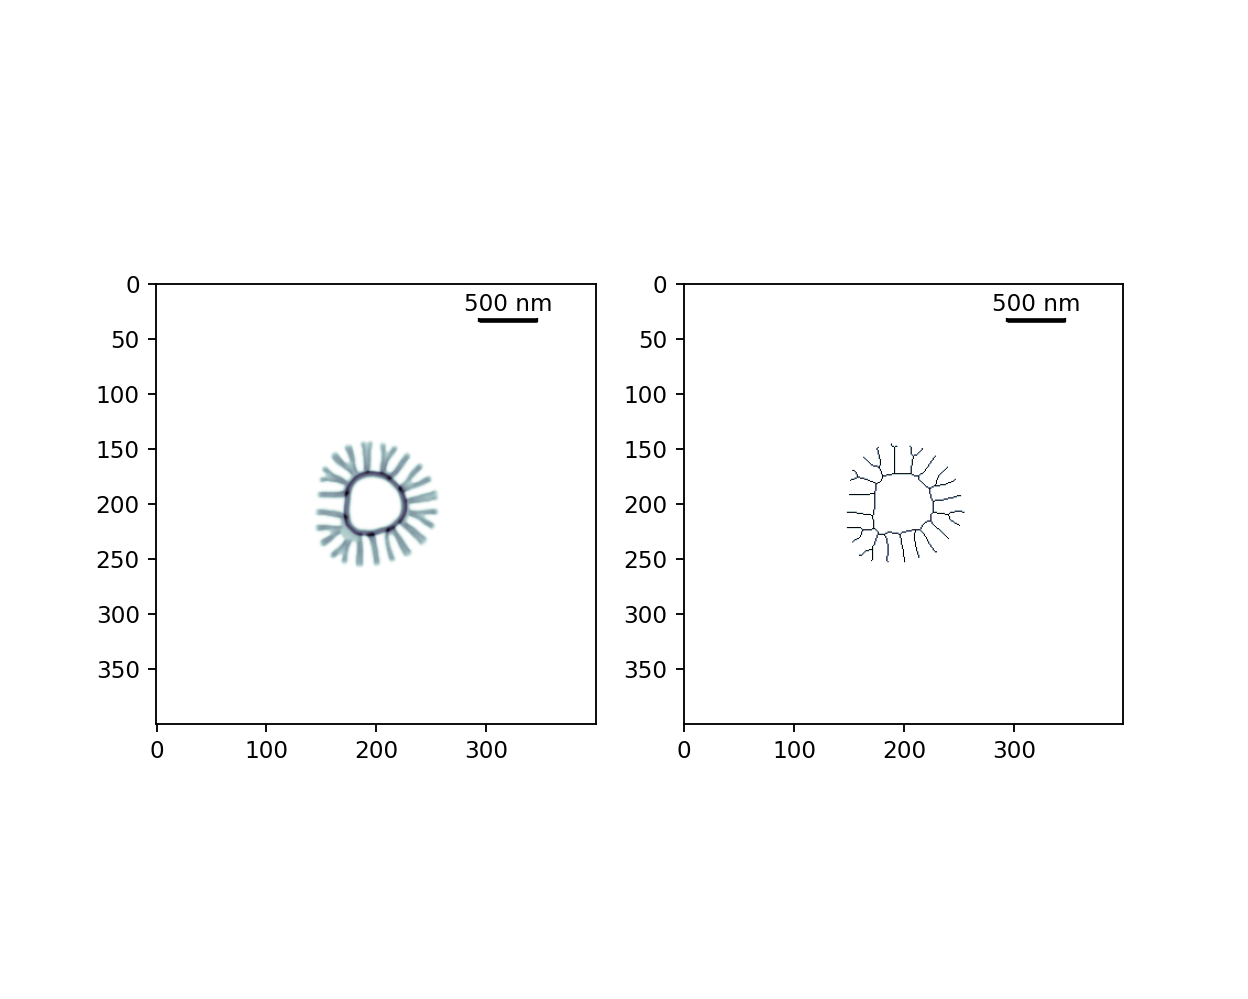

(<ErrorbarContainer object of 3 artists>, Text(320.0, 8.0, '500 nm'))

In [7]:
# Compute and plot skeleton of simulated rib pattern
S3_threshold = 10 
skel = mrph.skeletonize((S3>S3_threshold)*1)
skeleton_dilated = 1*mrph.binary_dilation(skel, selem=mrph.disk(.6))

fig, ax = plt.subplots(figsize=(7.5,6),dpi=150) #7.5,6

ax = plt.subplot(121)
im = ax.imshow(S3,cmap='bone_r')#,interpolation='bicubic')
plot_scale_bar(S3,mf,ax)

ax = plt.subplot(122)
im = ax.imshow(skeleton_dilated,cmap='bone_r')
plot_scale_bar(S3,mf,ax)

In [247]:
#ffmpeg -framerate 30 -f image2 -i S3_pattern%06d.png -r 30 -vf scale=800:-1 -c:v libx264  -crf 23  -pix_fmt yuv420p out2.mp4
